In [1]:
from interpret import *
from IPython.display import display, Markdown
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)
%matplotlib inline

/home/sca63/.conda/envs/bnn_chaos_model/lib/python3.7/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  "torch was imported before juliacall. This may cause a segfault. "


Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.


In [2]:
feature_nn = get_feature_nn(24880)
important_complexities = [1, 3, 4, 7, 11, 14, 22, 26]

In [3]:
results = get_pysr_results(pysr_version=11003, include_ssx=True, feature_nn=feature_nn)

In [4]:
results[:5]

,complexity,loss,score,equation,sympy_format
0,1,5.653270,0.000000,7.0051637,7.00516370000000
1,3,4.978444,0.063558,(6.990491 - m2),0.98404180377183 - m2
2,4,4.918939,0.012024,(7.1660094 - sin(m2)),7.1660094 - sin(m2 + 6.00644919622817)
3,5,4.030765,0.199137,((s4 ^ -0.15489304) * 3.6422653),3.6422653/s4**0.15489304
4,7,3.305422,0.099196,(((s4 ^ -0.15921338) * 3.5656016) - m2),-m2 + 3.5656016/s4**0.15921338 - 6.00644919622817


In [5]:
mapping_dict = get_mapping_dict(results, important_complexities)
print(mapping_dict)

{2: 0, 4: 1, 1: 2, 7: 3, 6: 4, 8: 5}


In [6]:
f2_str = f2_latex_str(results, important_complexities=important_complexities, mapping_dict=mapping_dict)
print(f2_str)

\begin{table}[h]
\begin{center}
\begin{tabular}{@{}ccc@{}}
\toprule
Equation & Complexity & Loss \\
\midrule
$y = 7.0$ & $1$ & $5.7$ \\
$y = 0.98 - \mu_{0}$ & $3$ & $5.0$ \\
$y = 7.2 - \sin{\left(\mu_{0} + 6.0 \right)}$ & $4$ & $4.9$ \\
$y = - \mu_{0} + \frac{3.6}{\sigma_{1}^{0.16}} - 6.0$ & $7$ & $3.3$ \\
\begin{minipage}{0.8\linewidth} \vspace{-1em} \begin{dmath*} y = 0.14^{\sigma_{2}} \left(- \mu_{0} + \sigma_{1}^{-0.31} - 6.0\right) + 3.7 \end{dmath*} \end{minipage} & $11$ & $2.7$ \\
\begin{minipage}{0.8\linewidth} \vspace{-1em} \begin{dmath*} y = 0.059^{\sigma_{2}} \left(\mu_{3} + \sigma_{1}^{-0.33} - \sin{\left(\mu_{0} + 6.0 \right)} - 0.72\right) + 3.7 \end{dmath*} \end{minipage} & $14$ & $2.5$ \\
\begin{minipage}{0.8\linewidth} \vspace{-1em} \begin{dmath*} y = 0.067^{\sigma_{2}} \left(\mu_{3} - \sigma_{5} + \left(\sigma_{4}^{0.35} \left(\sigma_{0} + \sigma_{1}\right)\right)^{-0.31} - \sin{\left(\mu_{0} + 6.0 \right)} - 0.72\right) + 3.7 \end{dmath*} \end{minipage} & $22$ & $2.2

In [7]:
f1_str = f1_latex_string(feature_nn, include_ssx=True, include_ssx_bias=True, mapping_dict=mapping_dict)
f1_str_nomap = f1_latex_string(feature_nn, include_ssx=True, include_ssx_bias=True)

In [8]:
# print(f1_str)
display(Markdown('$$\n' + f1_str + '\n$$'))
# display(Markdown('$$\n' + f1_str_nomap + '\n$$'))

$$
\begin{align*}
f_1& \text{ features:} \\ 
    &0: 27000  m_1 - 4.02  a_3 + 6.01 \\ 
    &1: 14.0  a_3 - 27.5  a_2 + 12.5 \\ 
    &2: 210  a_1 + 85400  m_1 - 211 \\ 
    &3: 58400  m_2 - 4.92  e_3 - 0.725 \\ 
    &4: 13.1  i_3 + 37.5  i_2 - 1.38 \\ 
    &5: 21.1  e_1 - 4.48  e_3 - 0.948 \\ 
\end{align*}
$$

In [11]:
# making the pareto plot
def make_pareto_plot(results, important_complexities=None, rmse=True, plot_unimportant=False):
    plt.figure(figsize=(10, 6))  # Width = 10 inches, Height = 6 inches
    ax = plt.gca()

    if rmse:
        rmse_vals = get_rmse_values()
        results['rmse'] = [rmse_vals[c] for c in results['complexity']]

    if plot_unimportant:
        plt.scatter(results['complexity'], results['rmse' if rmse else 'loss'], s=12)

    plt.xlabel('Equation complexity', fontsize=12, labelpad=10)

    plt.ylabel('RMSE' if rmse else 'Loss', fontsize=12, labelpad=10)

    if important_complexities:
        important_ixs = get_important_ixs(results, important_complexities)
        important_ys = [results['rmse' if rmse else 'loss'][i] for i in important_ixs]
        plt.scatter(important_complexities, important_ys, color='red' if plot_unimportant else None, s=16)

    plt.rcParams["font.family"] = "serif"

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tick_params(axis='both', which='major', labelsize=10)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    # Make minor ticks point outward
    ax.tick_params(axis="x", which="minor", direction="out")

    plt.ylim(1.25, 1.75)  # Set ymin to 3 and ymax to 7
    return plt


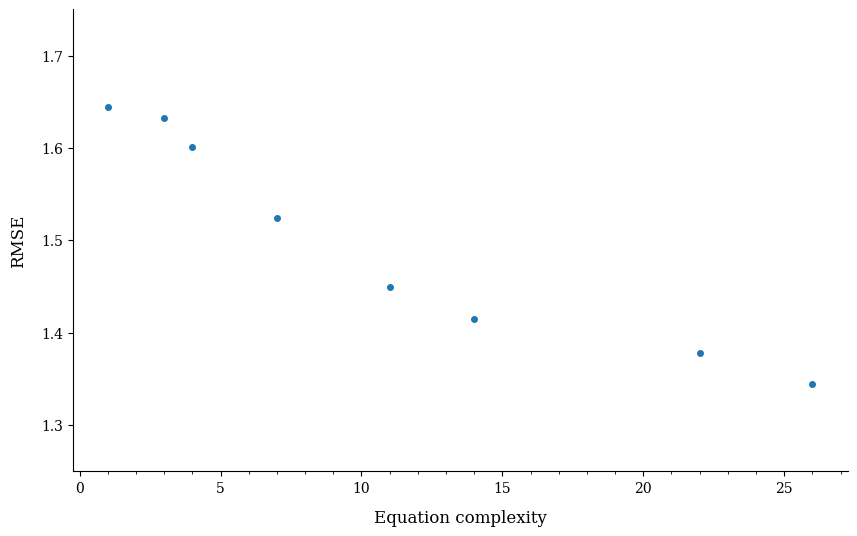

In [12]:
plt = make_pareto_plot(results, important_complexities, rmse=True, plot_unimportant=False)
plt.savefig('pareto_fig1.svg')
plt.show()


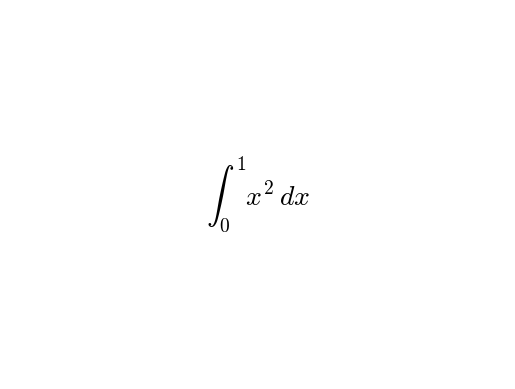

In [19]:
def save_latex_as_svg(latex_str, output_file):
    plt.rcParams["mathtext.fontset"] = "cm"
    fig, ax = plt.subplots()
    ax.set_axis_off()
    text = ax.text(0.5, 0.5, f"${latex_str}$", fontsize=20, ha='center', va='center', family="serif")

    fig.canvas.draw()  # update text positions
    renderer = fig.canvas.get_renderer()
    bbox = text.get_window_extent(renderer=renderer).transformed(fig.dpi_scale_trans.inverted())

    fig.savefig(output_file, format="svg", bbox_inches=bbox, pad_inches=0, transparent=True)

save_latex_as_svg(r"\int_0^1 x^2 \,dx", "output.svg")